<a href="https://colab.research.google.com/github/huggingface/blog/blob/master/notebooks/101_train-decision-transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Decision Transformers with 🤗 transformers

### Step 1: Install dependencies for model evaluation 🔽

!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common \
    patchelf \
    xvfb

### Step 2: Install and import the packages 📦



!pip install gym==0.21.0
!pip install free-mujoco-py
!pip install transformers
!pip install datasets
!pip install imageio-ffmpeg

!pip install colabgymrender==1.0.2
!pip install xvfbwrapper
!pip install imageio==2.4.1
!pip install imageio-ffmpeg
!pip install huggingface_hub


In [1]:
import os
import random
from dataclasses import dataclass
#import gym
import gymnasium as gym
import numpy as np
from stable_baselines3 import PPO
import torch
from datasets import load_dataset, Dataset, DatasetDict
from transformers import DecisionTransformerConfig, DecisionTransformerModel, Trainer, TrainingArguments, DecisionTransformerGymDataCollator
from tqdm.notebook import trange, tqdm

### Step 3: Loading the dataset from the 🤗 Hub and instantiating the model

We host a number of Offline RL Datasets on the hub. Today we will be training with the halfcheetah “expert” dataset, hosted here on hub.

First we need to import the load_dataset function from the 🤗 datasets package and download the dataset to our machine.

In [2]:
env = gym.make("CartPole-v1")
#env = gym.make('MountainCarContinuous-v0', render_mode="human")
env.reset()

(array([-0.04387875,  0.00520809,  0.00541686, -0.00326069], dtype=float32),
 {})

In [3]:
def one_hot(n, n_max):
  l = [0.0]*n_max
  l[n] = 1.0
  return l

In [4]:
def gen(nb_ep=10000, expert_demo=False):
  env = gym.make("CartPole-v1")
  if expert_demo:
    model = PPO("MlpPolicy", env, verbose=False)
    model.learn(total_timesteps=10_000)
  lenght_episode = 500
  for _ in trange(nb_ep):
    observations, actions, rewards, dones = [], [], [], []
    observation, _ = env.reset()
    done = False
    #for t in range(lenght_episode):
    while not done:
      #env.render()
      if done:
        reward = 0.0
      else:
        if expert_demo:
          action, _ = model.predict(observation, deterministic=True)
        else:
          action = env.action_space.sample()
        next_observation, reward, terminated, truncated, info = env.step(action)
        action = one_hot(int(action), 2)
        done = float(terminated or truncated)

      observations.append(list(observation))
      actions.append(action)
      rewards.append([reward])
      dones.append([done])

      observation = next_observation
      
    yield {
      'observations':observations, 
      'actions':actions, 
      'rewards':rewards,
      'dones':dones
    }

#next(gen())

In [5]:
def create_dataset(): #env, nb_episodes, lenght_episode):

  
  #train_dataset = Dataset.from_dict(dataset)
  train_dataset = Dataset.from_generator(gen)
  return DatasetDict({'train':train_dataset})
  
dataset = create_dataset() #env, 10000, 500)

Found cached dataset generator (/home/nono/.cache/huggingface/datasets/generator/default-92fa98eddf434ed5/0.0.0)


In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['observations', 'actions', 'rewards', 'dones'],
        num_rows: 10000
    })
})

In [7]:
#dataset_d = load_dataset("edbeeching/decision_transformer_gym_replay", "halfcheetah-expert-v2")
#dataset_d

In [8]:
dataset.save_to_disk("test.hf")

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

os.environ["WANDB_DISABLED"] = "true" # we diable weights and biases logging for this tutorial
dataset = load_dataset("edbeeching/decision_transformer_gym_replay", "halfcheetah-expert-v2")


### Step 4: Defining a custom DataCollator for the transformers Trainer class

In [9]:
@dataclass
class DecisionTransformerGymDataCollator:
    return_tensors: str = "pt"
    max_len: int = 20 #subsets of the episode we use for training
    state_dim: int = 2  # size of state space
    act_dim: int = 2  # size of action space
    max_ep_len: int = 1000 # max episode length in the dataset
    scale: float = 1000.0  # normalization of rewards/returns
    state_mean: np.array = None  # to store state means
    state_std: np.array = None  # to store state stds
    p_sample: np.array = None  # a distribution to take account trajectory lengths
    n_traj: int = 0 # to store the number of trajectories in the dataset

    def __init__(self, dataset) -> None:
        self.act_dim = len(dataset[0]["actions"][0])
        print('act_dim:', len(dataset[0]["actions"][0]))
        self.state_dim = len(dataset[0]["observations"][0])
        self.dataset = dataset
        # calculate dataset stats for normalization of states
        states = []
        traj_lens = []
        for obs in dataset["observations"]:
            states.extend(obs)
            traj_lens.append(len(obs))
        self.n_traj = len(traj_lens)
        states = np.vstack(states)
        self.state_mean, self.state_std = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6
        
        traj_lens = np.array(traj_lens)
        self.p_sample = traj_lens / sum(traj_lens)

    def _discount_cumsum(self, x, gamma):
        discount_cumsum = np.zeros_like(x)
        discount_cumsum[-1] = x[-1]
        for t in reversed(range(x.shape[0] - 1)):
            discount_cumsum[t] = x[t] + gamma * discount_cumsum[t + 1]
        return discount_cumsum

    def __call__(self, features):
        batch_size = len(features)
        # this is a bit of a hack to be able to sample of a non-uniform distribution
        batch_inds = np.random.choice(
            np.arange(self.n_traj),
            size=batch_size,
            replace=True,
            p=self.p_sample,  # reweights so we sample according to timesteps
        )
        # a batch of dataset features
        s, a, r, d, rtg, timesteps, mask = [], [], [], [], [], [], []
        
        for ind in batch_inds:
            # for feature in features:
            feature = self.dataset[int(ind)]
            si = random.randint(0, len(feature["rewards"]) - 1)

            # get sequences from dataset
            s.append(np.array(feature["observations"][si : si + self.max_len]).reshape(1, -1, self.state_dim))
            a.append(np.array(feature["actions"][si : si + self.max_len]).reshape(1, -1, self.act_dim))
            r.append(np.array(feature["rewards"][si : si + self.max_len]).reshape(1, -1, 1))

            d.append(np.array(feature["dones"][si : si + self.max_len]).reshape(1, -1))
            timesteps.append(np.arange(si, si + s[-1].shape[1]).reshape(1, -1))
            timesteps[-1][timesteps[-1] >= self.max_ep_len] = self.max_ep_len - 1  # padding cutoff
            rtg.append(
                self._discount_cumsum(np.array(feature["rewards"][si:]), gamma=1.0)[
                    : s[-1].shape[1]   # TODO check the +1 removed here
                ].reshape(1, -1, 1)
            )
            if rtg[-1].shape[1] < s[-1].shape[1]:
                print("if true")
                rtg[-1] = np.concatenate([rtg[-1], np.zeros((1, 1, 1))], axis=1)

            # padding and state + reward normalization
            tlen = s[-1].shape[1]
            s[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, self.state_dim)), s[-1]], axis=1)
            s[-1] = (s[-1] - self.state_mean) / self.state_std
            a[-1] = np.concatenate(
                [np.ones((1, self.max_len - tlen, self.act_dim)) * -10.0, a[-1]],
                axis=1,
            )
            r[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), r[-1]], axis=1)
            d[-1] = np.concatenate([np.ones((1, self.max_len - tlen)) * 2, d[-1]], axis=1)
            rtg[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), rtg[-1]], axis=1) / self.scale
            timesteps[-1] = np.concatenate([np.zeros((1, self.max_len - tlen)), timesteps[-1]], axis=1)
            mask.append(np.concatenate([np.zeros((1, self.max_len - tlen)), np.ones((1, tlen))], axis=1))

        s = torch.from_numpy(np.concatenate(s, axis=0)).float()
        a = torch.from_numpy(np.concatenate(a, axis=0)).float()
        r = torch.from_numpy(np.concatenate(r, axis=0)).float()
        d = torch.from_numpy(np.concatenate(d, axis=0))
        rtg = torch.from_numpy(np.concatenate(rtg, axis=0)).float()
        timesteps = torch.from_numpy(np.concatenate(timesteps, axis=0)).long()
        mask = torch.from_numpy(np.concatenate(mask, axis=0)).float()

        return {
            "states": s,
            "actions": a,
            "rewards": r,
            "returns_to_go": rtg,
            "timesteps": timesteps,
            "attention_mask": mask,
        }

### Step 5: Extending the Decision Transformer Model to include a loss function

In order to train the model with the 🤗 trainer class, we first need to ensure the dictionary it returns contains a loss, in this case L-2 norm of the models action predictions and the targets.

In [10]:
class TrainableDT(DecisionTransformerModel):
    def __init__(self, config, discrete_actions):
        super().__init__(config)
        self.discrete_actions = discrete_actions
        if self.discrete_actions:
            self.loss = torch.nn.BCELoss()
            #self.loss = torch.nn.CrossEntropyLoss()
            self.softmax = torch.nn.Softmax()
        else:
            self.loss = torch.nn.MSELoss()

        

    def forward(self, **kwargs):
        output = super().forward(**kwargs)
        # add the DT loss
        action_preds = output[1]
        action_targets = kwargs["actions"]
        attention_mask = kwargs["attention_mask"]
        act_dim = action_preds.shape[2]
        action_preds = action_preds.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        action_targets = action_targets.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        
        #loss = torch.mean((action_preds - action_targets) ** 2)
        #print(action_preds, action_targets)
        if self.discrete_actions:
            action_preds = self.softmax(action_preds)
        loss = self.loss(action_preds, action_targets)
        return {"loss": loss}

    def original_forward(self, **kwargs):
        return super().forward(**kwargs)

In [1]:
collator = DecisionTransformerGymDataCollator(dataset["train"])

config = DecisionTransformerConfig(state_dim=collator.state_dim, act_dim=collator.act_dim)
model = TrainableDT(config, discrete_actions=2)

NameError: name 'DecisionTransformerGymDataCollator' is not defined

In [ ]:
traj = collator(dataset['train'][0])

### Step 6: Defining the training hyperparameters and training the model
Here, we define the training hyperparameters and our Trainer class that we'll use to train our Decision Transformer model.

This step takes about an hour, so you may leave it running. Note the authors train for at least 3 hours, so the results presented here are not as performant as the models hosted on the 🤗 hub.

In [ ]:
dataset['train']['actions'][0][0]

[0.0, 1.0]

In [ ]:
loss = torch.nn.BCELoss()
loss(torch.tensor([[1.0, 0.0]]), torch.tensor([[1.0, 1.0]]))

tensor(50.)

In [ ]:
training_args = TrainingArguments(
    output_dir="output/",
    remove_unused_columns=False,
    num_train_epochs=120,
    per_device_train_batch_size=64,
    learning_rate=1e-4,
    weight_decay=1e-4,
    warmup_ratio=0.1,
    optim="adamw_torch",
    max_grad_norm=0.25,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    data_collator=collator,
)

trainer.train()

  0%|          | 0/18840 [00:00<?, ?it/s]

/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.6963, 'learning_rate': 2.653927813163482e-05, 'epoch': 3.18}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.6939, 'learning_rate': 5.307855626326964e-05, 'epoch': 6.37}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.6934, 'learning_rate': 7.961783439490447e-05, 'epoch': 9.55}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.6932, 'learning_rate': 9.931587638594009e-05, 'epoch': 12.74}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.693, 'learning_rate': 9.636706770464733e-05, 'epoch': 15.92}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.6885, 'learning_rate': 9.341825902335457e-05, 'epoch': 19.11}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.6637, 'learning_rate': 9.046945034206181e-05, 'epoch': 22.29}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.6448, 'learning_rate': 8.752064166076905e-05, 'epoch': 25.48}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.6319, 'learning_rate': 8.457183297947629e-05, 'epoch': 28.66}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.6244, 'learning_rate': 8.162302429818354e-05, 'epoch': 31.85}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.6189, 'learning_rate': 7.867421561689078e-05, 'epoch': 35.03}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.6145, 'learning_rate': 7.572540693559802e-05, 'epoch': 38.22}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.6099, 'learning_rate': 7.277659825430526e-05, 'epoch': 41.4}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.6059, 'learning_rate': 6.98277895730125e-05, 'epoch': 44.59}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.6028, 'learning_rate': 6.687898089171974e-05, 'epoch': 47.77}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.6003, 'learning_rate': 6.393017221042698e-05, 'epoch': 50.96}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.5979, 'learning_rate': 6.098136352913423e-05, 'epoch': 54.14}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.5938, 'learning_rate': 5.803255484784147e-05, 'epoch': 57.32}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.5919, 'learning_rate': 5.508374616654872e-05, 'epoch': 60.51}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.5901, 'learning_rate': 5.213493748525596e-05, 'epoch': 63.69}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.5876, 'learning_rate': 4.91861288039632e-05, 'epoch': 66.88}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.5852, 'learning_rate': 4.623732012267044e-05, 'epoch': 70.06}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.5844, 'learning_rate': 4.328851144137769e-05, 'epoch': 73.25}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.5824, 'learning_rate': 4.033970276008493e-05, 'epoch': 76.43}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.5798, 'learning_rate': 3.739089407879217e-05, 'epoch': 79.62}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.5785, 'learning_rate': 3.4442085397499415e-05, 'epoch': 82.8}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.5781, 'learning_rate': 3.1493276716206655e-05, 'epoch': 85.99}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.5763, 'learning_rate': 2.8544468034913895e-05, 'epoch': 89.17}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.5759, 'learning_rate': 2.559565935362114e-05, 'epoch': 92.36}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.5743, 'learning_rate': 2.264685067232838e-05, 'epoch': 95.54}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.5732, 'learning_rate': 1.9698041991035625e-05, 'epoch': 98.73}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.5723, 'learning_rate': 1.6749233309742865e-05, 'epoch': 101.91}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.5722, 'learning_rate': 1.3800424628450107e-05, 'epoch': 105.1}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.5705, 'learning_rate': 1.085161594715735e-05, 'epoch': 108.28}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.5704, 'learning_rate': 7.902807265864591e-06, 'epoch': 111.46}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.5695, 'learning_rate': 4.953998584571833e-06, 'epoch': 114.65}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'loss': 0.5691, 'learning_rate': 2.0051899032790755e-06, 'epoch': 117.83}


/tmp/ipykernel_405896/1264493018.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_preds = self.softmax(action_preds)


{'train_runtime': 909.7484, 'train_samples_per_second': 1319.046, 'train_steps_per_second': 20.709, 'train_loss': 0.6087039008008953, 'epoch': 120.0}


TrainOutput(global_step=18840, training_loss=0.6087039008008953, metrics={'train_runtime': 909.7484, 'train_samples_per_second': 1319.046, 'train_steps_per_second': 20.709, 'train_loss': 0.6087039008008953, 'epoch': 120.0})

In [ ]:
from pathlib import Path
path = Path.cwd()/'saved_models'/'DT_cartpole'
path

PosixPath('/home/nono/Documents/HuggingStuff/saved_models/DT_cartpole')

In [ ]:
trainer.save_model(path)

In [ ]:
#model = DecisionTransformerModel.from_pretrained(path)

### Step 7: Visualize the performance of the agent

In [ ]:
import gym

#from colabgymrender.recorder import Recorder

In [ ]:
# Function that gets an action from the model using autoregressive prediction with a window of the previous 20 timesteps.
def get_action(model, states, actions, rewards, returns_to_go, timesteps):
    # This implementation does not condition on past rewards

    states = states.reshape(1, -1, model.config.state_dim)
    #actions = actions.reshape(1, -1, 1)
    actions = actions.reshape(1, -1, model.config.act_dim)
    returns_to_go = returns_to_go.reshape(1, -1, 1)
    timesteps = timesteps.reshape(1, -1)

    states = states[:, -model.config.max_length :]
    actions = actions[:, -model.config.max_length :]
    returns_to_go = returns_to_go[:, -model.config.max_length :]
    timesteps = timesteps[:, -model.config.max_length :]
    padding = model.config.max_length - states.shape[1]
    # pad all tokens to sequence length
    attention_mask = torch.cat([torch.zeros(padding), torch.ones(states.shape[1])])
    attention_mask = attention_mask.to(dtype=torch.long).reshape(1, -1)
    states = torch.cat([torch.zeros((1, padding, model.config.state_dim)), states], dim=1).float()
    #actions = torch.cat([torch.zeros((1, padding, 1)), actions], dim=1).float()
    actions = torch.cat([torch.zeros((1, padding, model.config.act_dim)), actions], dim=1).float()
    returns_to_go = torch.cat([torch.zeros((1, padding, 1)), returns_to_go], dim=1).float()
    timesteps = torch.cat([torch.zeros((1, padding), dtype=torch.long), timesteps], dim=1)

    state_preds, action_preds, return_preds = model.original_forward(
        states=states,
        actions=actions,
        rewards=rewards,
        returns_to_go=returns_to_go,
        timesteps=timesteps,
        attention_mask=attention_mask,
        return_dict=False,
    )

    return action_preds[0, -1]

In [ ]:
env.action_space.shape

()

In [ ]:
model

TrainableDT(
  (encoder): DecisionTransformerGPT2Model(
    (wte): Embedding(1, 128)
    (wpe): Embedding(1024, 128)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-2): 3 x DecisionTransformerGPT2Block(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): DecisionTransformerGPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): DecisionTransformerGPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): ReLU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (embed_timestep): Embedding(4096, 128)
  (embed_return): Linear(in_features=1, out_features=128, bias=True)
  (embed_state): Linear(

In [ ]:
def evaluate(model, target_return, nb_ep, render=False, progress_bar=False):
    # build the environment
    model = model.to("cpu")
    #env = gym.make('MountainCarContinuous-v0', render_mode="human")
    env = gym.make("CartPole-v1", render_mode="human" if render else None)
    #env = Recorder(env, directory, fps=30)
    max_ep_len = 1000
    device = "cpu"
    scale = 100.0  # normalization for rewards/returns
    TARGET_RETURN = target_return # 12000 / scale  # evaluation is conditioned on a return of 12000, scaled accordingly

    state_mean = collator.state_mean.astype(np.float32)
    state_std = collator.state_std.astype(np.float32)
    #print(state_mean)

    state_dim = env.observation_space.shape[0]
    act_dim = 2 #env.action_space.shape[0]
    # Create the decision transformer model

    state_mean = torch.from_numpy(state_mean).to(device=device)
    state_std = torch.from_numpy(state_std).to(device=device)

    episodes_returns, episodes_lengths = [], []
    pbar = trange(nb_ep) if progress_bar else range(nb_ep)
    for ep in pbar:
        #run_ep(env, )
        # Interact with the environment and create a video
        episode_return, episode_length = 0.0, 0
        state, _ = env.reset()
        target_return = torch.tensor(TARGET_RETURN, device=device, dtype=torch.float32).reshape(1, 1)
        states = torch.from_numpy(state).reshape(1, state_dim).to(device=device, dtype=torch.float32)
        actions = torch.zeros((0, act_dim), device=device, dtype=torch.float32)
        rewards = torch.zeros(0, device=device, dtype=torch.float32)

        timesteps = torch.tensor(0, device=device, dtype=torch.long).reshape(1, 1)
        for t in range(max_ep_len):
            if render:
                env.render()
            actions = torch.cat([actions, torch.zeros((1, act_dim), device=device)], dim=0)
            rewards = torch.cat([rewards, torch.zeros(1, device=device)])

            action = get_action(
                model,
                (states - state_mean) / state_std,
                actions,
                rewards,
                target_return,
                timesteps,
            )
            action_int = action.argmax()
            action = torch.tensor(one_hot(action_int, act_dim))
            #print("action", action)
            actions[-1] = action
            action = action.detach().cpu().numpy()
            state, reward, terminated, truncated, _ = env.step(int(action_int))
            done = terminated or truncated

            cur_state = torch.from_numpy(state).to(device=device).reshape(1, state_dim)
            states = torch.cat([states, cur_state], dim=0)
            rewards[-1] = reward

            pred_return = target_return[0, -1] - (reward / scale)
            target_return = torch.cat([target_return, pred_return.reshape(1, 1)], dim=1)
            timesteps = torch.cat([timesteps, torch.ones((1, 1), device=device, dtype=torch.long) * (t + 1)], dim=1)

            episode_return += reward
            episode_length += 1

            if done:
                break

        episodes_returns.append(episode_return) 
        episodes_lengths.append(episode_length)

    env.close()
    return np.array(episodes_returns), np.array(episodes_lengths)


In [ ]:

episodes_returns, episodes_lengths = evaluate(model, target_return=5.0, nb_ep=1, render=True)
print("Episode return:", episodes_returns)
print("Episode lenght:", episodes_lengths)

In [ ]:
episodes_returns, _ = evaluate(model, target_return=5.0, nb_ep=10, render=False)
print("Mean episode return:", episodes_returns.mean())
print("Std episode return:", episodes_returns.std())


Mean episode return: 435.5
Std episode return: 102.3281486200156


In [ ]:
target_returns = np.linspace(0.0, 10.0, 10)
mean_return, std_return = [], []
for target_return in tqdm(target_returns):
  episodes_returns, _ = evaluate(model, target_return=target_return, nb_ep=10, render=False)
  mean_return.append(episodes_returns.mean())
  std_return.append(episodes_returns.std())

mean_return, std_return = np.array(mean_return), np.array(std_return)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt

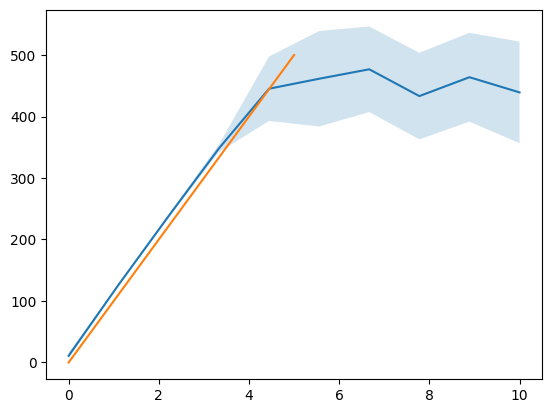

In [ ]:
fig, ax = plt.subplots()
ax.plot(target_returns, mean_return, '-')
ax.fill_between(target_returns, mean_return - std_return, mean_return + std_return, alpha=0.2)

X = np.linspace(0.0, 5.0, 10)
ax.plot(X, 100*X)

In [ ]:
evaluate(model, target_return=100, nb_ep=10, render=False)

(array([351., 263., 263., 275., 500., 500., 365., 270., 500., 500.]),
 array([351, 263, 263, 275, 500, 500, 365, 270, 500, 500]))

### Step 8: Publish our trained model on the Hub 🔥
Now that we saw we got good results after the training, we can publish our trained model on the hub 🤗 with one line of code.

Under the hood, the Hub uses git-based repositories (don't worry if you don't know what git is), which means you can update the model with new versions as you experiment and improve your agent.

To be able to share your model with the community there are three more steps to follow:

1️⃣ (If it's not already done) create an account to HF ➡ https://huggingface.co/join

2️⃣ Sign in and then, you need to store your authentication token from the Hugging Face website.
- Create a new token (https://huggingface.co/settings/tokens) **with write role**

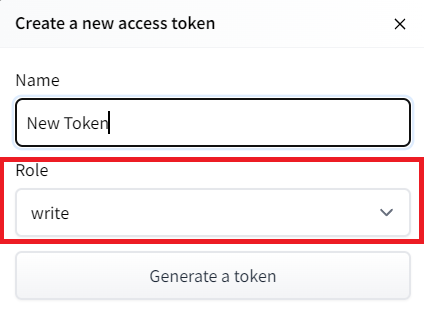

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

If you don't want to use a Google Colab or a Jupyter Notebook, you need to use this command instead: `huggingface-cli login`

3️⃣ We're now ready to push our trained model to the 🤗 Hub 🔥 !!

In [ ]:
#trainer.push_to_hub()

## Some additional challenges 🏆
Congratulations, you've just trained your first Decision Transformer 🥳.

Now, the best way to learn **is to try things by your own**! Why not trying with another environment?

We provide datasets for some other environments:
* [Walker2D](https://huggingface.co/edbeeching/decision-transformer-gym-walker2d-expert)
* [Hopper](https://huggingface.co/edbeeching/decision-transformer-gym-hopper-expert)


Have fun!

### Keep Learning, Stay awesome 🤗
